In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from json import JSONDecodeError
import itertools

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from api_info import *
from credentials import *
from api_functions import *
from stat_functions import *

In [9]:
d = retrieve_espn_data(swid,espn_s2,league_id)
data = clean_data(d)

Player has irregular eligible slots: Elias N. Pettersson has slots [10, 4, 6, 7, 8]


In [6]:

scoring_weights = {
    "FOW": 1,
    "assists": 1,
    "average_time_on_ice": 1,
    "blocks": 1,
    "goals": 1,
    "hits": 1,
    "penalty_minutes": 1,
    "plus_minus": 0,
    "power play points": 1,
    "shots_on_goal": 1,
}

In [15]:
games = pd.read_csv("playoff_week_2_games.csv")
away_team_number = dict(games["Away Team"].value_counts())
home_team_number = dict(games["Home Team"].value_counts())
team_total_plays = {}
for team in team_dict.values():
    if team not in away_team_number:
        away_team_number[team] = 0
    if team not in home_team_number:
        home_team_number[team] = 0
    team_total_plays[team] = int(away_team_number[team] + home_team_number[team])
team_total_plays[np.nan] = 0


weekend_games = games[games["Day"].isin(["Saturday", "Sunday"])]
away_team_number = dict(weekend_games["Away Team"].value_counts())
home_team_number = dict(weekend_games["Home Team"].value_counts())
team_weekend_plays = {}
for team in team_dict.values():
    if team not in away_team_number:
        away_team_number[team] = 0
    if team not in home_team_number:
        home_team_number[team] = 0
    team_weekend_plays[team] = int(away_team_number[team] + home_team_number[team])
team_weekend_plays[np.nan] = 0


skater_data = data[(data["Position"] != "GK")].copy()

played_players = skater_data  # [skater_data['games_played so far']>=3]
played_players = skater_data[(skater_data["games_playedAT"] >= 2)]
for addition in [" week", " weekend"]:
    for stat_name in all_stats_names:
        played_players["sum scores " + stat_name + addition] = 0

played_players["Team"] = played_players["TeamID"].map(team_dict)
played_players["Games in playoff"] = played_players["Team"].apply(
    lambda x: team_total_plays[x]
)
played_players["Games in playoff weekend"] = played_players["Team"].apply(
    lambda x: team_weekend_plays[x]
)

for cat in scoring_weights:
    if cat != "average_time_on_ice":
        for stat_name in all_stats_names:
            played_players[cat + stat_name + " week"] = (
                played_players[cat + stat_name] * played_players["Games in playoff"]
            )
            played_players[cat + stat_name + " weekend"] = (
                played_players[cat + stat_name]
                * played_players["Games in playoff weekend"]
            )
    else:
        for stat_name in all_stats_names:
            played_players[cat + stat_name + " week"] = played_players[cat + stat_name]
            played_players[cat + stat_name + " weekend"] = played_players[
                cat + stat_name
            ]

C:\Users\georg\AppData\Local\Temp\ipykernel_1960\1382447666.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  played_players["sum scores " + stat_name + addition] = 0
C:\Users\georg\AppData\Local\Temp\ipykernel_1960\1382447666.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  played_players["sum scores " + stat_name + addition] = 0
C:\Users\georg\AppData\Local\Temp\ipykernel_1960\1382447666.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [16]:
played_players.columns

Index(['index', 'ID', 'Name', 'TeamID', 'LeagueTeamID', 'Position',
       'InjuryStatus', 'FOLproj', 'FOWproj', 'assistsproj',
       ...
       'power play pointsAT week', 'power play pointsAT weekend',
       'shots_on_goalproj week', 'shots_on_goalproj weekend',
       'shots_on_goal15 week', 'shots_on_goal15 weekend',
       'shots_on_goal30 week', 'shots_on_goal30 weekend',
       'shots_on_goalAT week', 'shots_on_goalAT weekend'],
      dtype='object', length=198)

In [17]:
for cat in scoring_weights:
    for stat_name in all_stats_names:
        # cat_team_mean = played_players[~played_players["LeagueTeamID"].isna()][cat+stat_name].mean()
        # cat_team_std = played_players[~played_players["LeagueTeamID"].isna()][cat+stat_name].std()
        cat_team_mean = played_players[played_players["LeagueTeamID"] == 3][
            cat + "AT"
        ].mean()
        cat_team_std = played_players[played_players["LeagueTeamID"] == 3][
            cat + "AT"
        ].std()
        for addition in [" week", " weekend"]:
            played_players[cat + " stat" + addition] = (
                played_players[cat + stat_name + addition] - cat_team_mean
            ) / cat_team_std
            # played_players[cat+" stat"]=(played_players[cat+ " so far"]-played_players[cat+ " so far"].mean())/played_players[cat+ " so far"].std()
            if cat in scoring_weights:
                played_players["sum scores " + stat_name + addition] += (
                    played_players[cat + " stat" + addition] * scoring_weights[cat]
                )

played_players = played_players[
    ["ID", "Name", "TeamID", "LeagueTeamID", "Position", "InjuryStatus"]
    + ["sum scores " + stat_name + " week" for stat_name in all_stats_names]
    + ["sum scores " + stat_name + " weekend" for stat_name in all_stats_names]
    + ["games_played" + stat_name for stat_name in all_stats_names]
]
# played_players=played_players[played_players["InjuryStatus"]!='INJURY_RESERVE']

my_players = played_players[(played_players["LeagueTeamID"] == 8)]
available_players = played_players[
    (played_players["InjuryStatus"] == "ACTIVE")
    & (played_players["LeagueTeamID"].isna())
]

C:\Users\georg\AppData\Local\Temp\ipykernel_1960\2008159091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  played_players[cat + " stat" + addition] = (
C:\Users\georg\AppData\Local\Temp\ipykernel_1960\2008159091.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  played_players["sum scores " + stat_name + addition] += (
C:\Users\georg\AppData\Local\Temp\ipykernel_1960\2008159091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [19]:
teams_not_playing_saturday = [
    "Anaheim Ducks",
    "Pittsburgh Penguins",
    "Columbus Blue Jackets",
    "Winnipeg Jets",
]

reversed_team_ids = {v: k for k, v in team_dict.items()}
team_ids_not_playing_saturday = [
    reversed_team_ids[team] for team in teams_not_playing_saturday
]

In [ ]:
played_players[
    (played_players["Position"] == "D")
    & (played_players["TeamID"].isin(team_ids_not_playing_saturday))
].sort_values(by="sum scores AT week", ascending=False).iloc[0:10]

,ID,Name,TeamID,LeagueTeamID,Position,InjuryStatus,sum scores proj week,sum scores 15 week,sum scores 30 week,sum scores AT week,sum scores proj weekend,sum scores 15 weekend,sum scores 30 weekend,sum scores AT weekend,games_playedproj,games_played15,games_played30,games_playedAT
122,3899972,Zach Werenski,29,8.0,D,ACTIVE,NaN,41.335119,32.094946,42.113838,NaN,-13.071863,-12.567739,-12.688350,72.0,2.0,7.0,56.0
212,3988847,Neal Pionk,28,8.0,D,ACTIVE,NaN,61.635321,34.045495,25.456637,NaN,11.472164,1.995713,-1.129423,82.0,1.0,8.0,57.0
255,5502,Radko Gudas,25,1.0,D,ACTIVE,NaN,28.146616,24.036439,23.496779,NaN,-0.704707,-2.202754,-2.550430,74.0,2.0,7.0,55.0
135,3539,Kris Letang,16,8.0,D,ACTIVE,NaN,40.923881,25.695547,23.018905,NaN,4.191714,-0.817877,-1.623184,76.0,3.0,9.0,52.0
83,5164,Erik Karlsson,16,2.0,D,ACTIVE,NaN,19.999146,17.458155,20.575744,NaN,-2.226674,-3.088662,-2.527781,82.0,3.0,9.0,59.0
92,2976839,Jacob Trouba,25,3.0,D,ACTIVE,NaN,5.704640,15.817559,19.104692,NaN,-8.091908,-4.857607,-3.699019,76.0,3.0,8.0,55.0
1267,4565262,Jackson LaCombe,25,7.0,D,ACTIVE,NaN,23.235927,31.352245,17.903283,NaN,-1.279852,1.094274,-3.947625,NaN,3.0,8.0,49.0
1358,4024959,Dante Fabbro,29,NaN,D,ACTIVE,NaN,17.181746,18.875281,13.060938,NaN,-14.254476,-15.278985,-15.114845,NaN,1.0,5.0,44.0
1428,4233878,Dylan Samberg,28,NaN,D,ACTIVE,NaN,14.685945,15.181018,12.785371,NaN,-3.600024,-4.429469,-5.624155,NaN,1.0,8.0,36.0
1357,4024968,Logan Stanley,28,NaN,D,ACTIVE,NaN,11.877100,1.369235,12.327779,NaN,-5.396387,-10.866341,-7.084277,NaN,1.0,8.0,43.0


In [ ]:
played_players[
    (played_players["TeamID"].isin(team_ids_not_playing_saturday))
].sort_values(by="sum scores AT week", ascending=False).iloc[0:10]

,ID,Name,TeamID,LeagueTeamID,Position,InjuryStatus,sum scores proj week,sum scores 15 week,sum scores 30 week,sum scores AT week,sum scores proj weekend,sum scores 15 weekend,sum scores 30 weekend,sum scores AT weekend,games_playedproj,games_played15,games_played30,games_playedAT
122,3899972,Zach Werenski,29,8.0,D,ACTIVE,NaN,41.335119,32.094946,42.113838,NaN,-13.071863,-12.567739,-12.688350,72.0,2.0,7.0,56.0
17,3114,Sidney Crosby,16,8.0,C,ACTIVE,NaN,30.551419,41.578955,40.541040,NaN,0.396237,4.145261,3.432871,82.0,2.0,7.0,57.0
140,2562632,Mark Scheifele,28,8.0,C,ACTIVE,NaN,21.133606,27.367019,40.249068,NaN,-2.399423,-1.133743,3.312321,78.0,1.0,8.0,57.0
25,3899952,Kyle Connor,28,3.0,LW,ACTIVE,NaN,48.512146,31.490555,36.347095,NaN,6.642435,0.293471,1.963363,78.0,1.0,8.0,57.0
204,2562629,Rickard Rakell,16,1.0,LWRW,ACTIVE,NaN,10.210123,24.987409,27.372486,NaN,-6.581649,-1.532683,-1.247408,73.0,3.0,9.0,58.0
36,3527554,Frank Vatrano,25,3.0,RW,ACTIVE,NaN,23.863697,23.004583,27.235242,NaN,-2.325583,-3.109102,-1.630677,81.0,3.0,8.0,55.0
156,4587996,Kirill Marchenko,29,7.0,LWRW,ACTIVE,NaN,5.007643,6.598842,27.071325,NaN,-16.682942,-16.082149,-15.748025,75.0,1.0,5.0,54.0
212,3988847,Neal Pionk,28,8.0,D,ACTIVE,NaN,61.635321,34.045495,25.456637,NaN,11.472164,1.995713,-1.129423,82.0,1.0,8.0,57.0
1112,4064781,Mathieu Olivier,29,NaN,C,ACTIVE,NaN,33.691973,21.183862,25.399435,NaN,-15.936694,-16.767527,-17.382702,NaN,2.0,8.0,57.0
234,4915856,Dmitri Voronkov,29,8.0,LW,ACTIVE,NaN,28.749050,13.835538,25.370094,NaN,-15.844995,-15.538274,-16.232875,76.0,2.0,8.0,48.0


In [ ]:

played_players[
    (played_players["LeagueTeamID"].isna())
    & (played_players["Position"] == "D")
    & (played_players["TeamID"].isin(team_ids_not_playing_saturday))
].sort_values(by="sum scores AT week", ascending=False).iloc[0:10]

,ID,Name,TeamID,LeagueTeamID,Position,InjuryStatus,sum scores proj week,sum scores 15 week,sum scores 30 week,sum scores AT week,sum scores proj weekend,sum scores 15 weekend,sum scores 30 weekend,sum scores AT weekend,games_playedproj,games_played15,games_played30,games_playedAT
1358,4024959,Dante Fabbro,29,NaN,D,ACTIVE,NaN,17.181746,18.875281,13.060938,NaN,-14.254476,-15.278985,-15.114845,NaN,1.0,5.0,44.0
1428,4233878,Dylan Samberg,28,NaN,D,ACTIVE,NaN,14.685945,15.181018,12.785371,NaN,-3.600024,-4.429469,-5.624155,NaN,1.0,8.0,36.0
1357,4024968,Logan Stanley,28,NaN,D,ACTIVE,NaN,11.877100,1.369235,12.327779,NaN,-5.396387,-10.866341,-7.084277,NaN,1.0,8.0,43.0
839,4874863,Olen Zellweger,25,NaN,D,ACTIVE,NaN,1.975471,1.858879,10.493536,NaN,-10.407257,-10.353085,-6.977486,NaN,3.0,5.0,43.0
1273,4565270,Drew Helleson,25,NaN,D,ACTIVE,NaN,8.020020,4.315562,9.936973,NaN,-7.837289,-9.535351,-7.860230,NaN,3.0,8.0,30.0
265,3899939,Ivan Provorov,29,NaN,D,ACTIVE,NaN,-4.647726,16.758893,8.983555,NaN,-13.277397,-13.302694,-13.896552,82.0,2.0,8.0,57.0
320,2590861,Dylan DeMelo,28,NaN,D,ACTIVE,NaN,-14.191234,14.308796,8.412660,NaN,-14.191234,-5.093333,-7.010236,77.0,1.0,8.0,57.0
1093,3069448,Matt Grzelcyk,16,NaN,D,DAY_TO_DAY,NaN,-9.806743,-3.395519,8.267942,NaN,-14.795620,-11.577353,-7.419005,NaN,3.0,9.0,59.0
310,5080154,Pavel Mintyukov,25,NaN,D,ACTIVE,NaN,7.482245,7.157353,6.621353,NaN,-8.800739,-8.546453,-8.260967,77.0,1.0,4.0,44.0
1068,4392260,Vincent Desharnais,16,NaN,D,ACTIVE,NaN,10.976273,4.978691,5.990581,NaN,-7.695088,-9.784928,-9.239476,NaN,2.0,6.0,39.0


In [ ]:
teams_playing_all_weekend = [
    "Boston Bruins",
    "Buffalo Sabres",
    "Carolina Hurricanes",
    "Chicago Blackhawks",
    "Florida Panthers",
    "Los Angeles Kings",
    "Nashville Predators",
    "Philadelphia Flyers",
    "St. Louis Blues",
    "Tampa Bay Lightning",
    "Vegas Golden Knights",
]
reversed_team_ids = {v: k for k, v in team_dict.items()}
team_ids_playing_all_weekend = [
    reversed_team_ids[team] for team in teams_playing_all_weekend
]
played_players[
    (played_players["LeagueTeamID"].isna())
    & (played_players["TeamID"].isin(team_ids_playing_all_weekend))
].sort_values(by="sum scores AT weekend", ascending=False).iloc[0:10]

,ID,Name,TeamID,LeagueTeamID,Position,InjuryStatus,sum scores proj week,sum scores 15 week,sum scores 30 week,sum scores AT week,sum scores proj weekend,sum scores 15 weekend,sum scores 30 weekend,sum scores AT weekend,games_playedproj,games_played15,games_played30,games_playedAT
288,2593315,Jason Zucker,2,NaN,LWRW,ACTIVE,NaN,63.420748,40.240344,40.625032,NaN,23.242421,11.743015,11.935010,72.0,2.0,7.0,53.0
309,4697395,Anton Lundell,26,NaN,CLW,ACTIVE,NaN,16.354567,14.325458,22.869520,NaN,5.209257,3.900318,9.744946,77.0,2.0,9.0,57.0
770,4587985,Mark Kastelic,1,NaN,C,ACTIVE,NaN,7.713579,3.743860,37.054286,NaN,-6.084687,-8.064803,9.166002,NaN,2.0,4.0,49.0
436,3115033,Ryan Donato,4,NaN,CRW,ACTIVE,NaN,48.376848,50.009028,35.387529,NaN,16.463556,16.834427,9.141930,77.0,3.0,10.0,55.0
324,3025662,Shayne Gostisbehere,7,NaN,D,ACTIVE,NaN,12.703075,5.570928,20.281141,NaN,2.745417,-1.767450,8.234299,79.0,2.0,8.0,49.0
793,5149170,Matvei Michkov,15,NaN,RW,ACTIVE,NaN,46.891049,11.781874,31.132004,NaN,15.126188,-2.730552,7.174559,NaN,2.0,9.0,56.0
352,3535,Nick Foligno,4,NaN,LW,ACTIVE,NaN,45.528676,35.558033,30.468456,NaN,14.357517,9.147900,6.911504,74.0,3.0,10.0,56.0
77,4392072,Owen Tippett,15,NaN,LWRW,ACTIVE,NaN,72.328477,18.645000,30.104644,NaN,26.870986,0.219762,6.771229,78.0,1.0,4.0,53.0
225,3042111,Nick Paul,20,NaN,CRW,ACTIVE,NaN,25.581238,18.790084,29.496812,NaN,4.667331,1.080765,6.449180,81.0,3.0,10.0,50.0
385,2562618,Connor Murphy,4,NaN,D,ACTIVE,NaN,7.634834,3.586253,27.283904,NaN,-3.540651,-5.506444,6.140800,62.0,3.0,6.0,44.0


In [ ]:
played_players[
    (played_players["LeagueTeamID"].isna()) & (played_players["Position"] == "D")
].sort_values(by="sum scores AT week", ascending=False).iloc[0:10]

,ID,Name,TeamID,LeagueTeamID,Position,InjuryStatus,sum scores proj week,sum scores 15 week,sum scores 30 week,sum scores AT week,sum scores proj weekend,sum scores 15 weekend,sum scores 30 weekend,sum scores AT weekend,games_playedproj,games_played15,games_played30,games_playedAT
1141,3942030,Dennis Gilbert,2,NaN,D,ACTIVE,NaN,27.524602,35.929619,28.591652,NaN,4.734662,8.460489,4.753222,NaN,2.0,4.0,21.0
464,4874722,Brandt Clarke,8,NaN,D,ACTIVE,NaN,14.864471,13.266223,27.293082,NaN,-2.262600,-2.394528,5.354082,40.0,2.0,7.0,52.0
385,2562618,Connor Murphy,4,NaN,D,ACTIVE,NaN,7.634834,3.586253,27.283904,NaN,-3.540651,-5.506444,6.140800,62.0,3.0,6.0,44.0
167,2976856,Brady Skjei,27,NaN,D,ACTIVE,NaN,35.676241,21.762280,22.401791,NaN,10.514835,3.345644,3.825040,81.0,3.0,9.0,56.0
1264,4565266,Alex Vlasic,4,NaN,D,ACTIVE,NaN,20.118900,10.242987,22.191446,NaN,2.984913,-1.862503,4.165976,NaN,3.0,10.0,57.0
743,4587904,Tyler Tucker,19,NaN,D,ACTIVE,NaN,1.930797,20.683559,22.158586,NaN,-7.622714,1.716355,2.127702,NaN,1.0,5.0,20.0
377,4565225,Bowen Byram,2,NaN,D,ACTIVE,NaN,28.893253,26.278579,22.097354,NaN,7.246661,6.014311,4.004343,74.0,2.0,7.0,55.0
432,5092,Luke Schenn,27,NaN,D,ACTIVE,NaN,24.460185,15.110551,22.032428,NaN,4.018266,-0.952379,2.511445,69.0,3.0,9.0,56.0
1177,5146599,Emil Lilleberg,20,NaN,D,ACTIVE,NaN,8.989660,8.872075,21.057987,NaN,-3.960475,-3.992390,2.099667,NaN,3.0,8.0,51.0
1170,4392769,Brayden Pachal,3,NaN,D,ACTIVE,NaN,-8.423026,12.155575,20.832384,NaN,-15.208479,-9.951891,-7.789431,NaN,2.0,10.0,56.0


In [27]:
played_players[(played_players["LeagueTeamID"].isna())].sort_values(
    by="sum scores AT week", ascending=False
).iloc[0:10]

,ID,Name,TeamID,LeagueTeamID,Position,InjuryStatus,sum scores proj week,sum scores 15 week,sum scores 30 week,sum scores AT week,sum scores proj weekend,sum scores 15 weekend,sum scores 30 weekend,sum scores AT weekend,games_playedproj,games_played15,games_played30,games_playedAT
288,2593315,Jason Zucker,2,NaN,LWRW,ACTIVE,NaN,63.420748,40.240344,40.625032,NaN,23.242421,11.743015,11.935010,72.0,2.0,7.0,53.0
770,4587985,Mark Kastelic,1,NaN,C,ACTIVE,NaN,7.713579,3.743860,37.054286,NaN,-6.084687,-8.064803,9.166002,NaN,2.0,4.0,49.0
436,3115033,Ryan Donato,4,NaN,CRW,ACTIVE,NaN,48.376848,50.009028,35.387529,NaN,16.463556,16.834427,9.141930,77.0,3.0,10.0,55.0
155,3797,Mikael Backlund,3,NaN,C,ACTIVE,NaN,35.640187,22.144614,32.055795,NaN,-2.957098,-6.376051,-3.678379,82.0,2.0,10.0,56.0
793,5149170,Matvei Michkov,15,NaN,RW,ACTIVE,NaN,46.891049,11.781874,31.132004,NaN,15.126188,-2.730552,7.174559,NaN,2.0,9.0,56.0
352,3535,Nick Foligno,4,NaN,LW,ACTIVE,NaN,45.528676,35.558033,30.468456,NaN,14.357517,9.147900,6.911504,74.0,3.0,10.0,56.0
77,4392072,Owen Tippett,15,NaN,LWRW,ACTIVE,NaN,72.328477,18.645000,30.104644,NaN,26.870986,0.219762,6.771229,78.0,1.0,4.0,53.0
225,3042111,Nick Paul,20,NaN,CRW,ACTIVE,NaN,25.581238,18.790084,29.496812,NaN,4.667331,1.080765,6.449180,81.0,3.0,10.0,50.0
266,4697409,Jake Neighbours,19,NaN,LWRW,ACTIVE,NaN,2.759127,12.111131,29.039782,NaN,-7.164280,-2.613004,6.136986,78.0,3.0,9.0,58.0
277,4233685,Morgan Frost,3,NaN,C,ACTIVE,NaN,65.106333,27.485081,28.677877,NaN,3.560424,-5.747656,-5.605850,73.0,2.0,10.0,55.0


In [28]:
my_players.sort_values(by="sum scores 30 week", ascending=True)

,ID,Name,TeamID,LeagueTeamID,Position,InjuryStatus,sum scores proj week,sum scores 15 week,sum scores 30 week,sum scores AT week,sum scores proj weekend,sum scores 15 weekend,sum scores 30 weekend,sum scores AT weekend,games_playedproj,games_played15,games_played30,games_playedAT
234,4915856,Dmitri Voronkov,29,8.0,LW,ACTIVE,NaN,28.749050,13.835538,25.370094,NaN,-15.844995,-15.538274,-16.232875,76.0,2.0,8.0,48.0
407,4391255,Kiefer Sherwood,22,8.0,LWRW,ACTIVE,NaN,19.763503,17.287261,23.109857,NaN,-4.604395,-5.623047,-3.826125,76.0,3.0,6.0,53.0
170,3904189,Vince Dunn,124292,8.0,D,ACTIVE,NaN,10.790393,22.570496,23.157043,NaN,-5.449443,-1.720196,-1.922019,76.0,3.0,10.0,39.0
21,3891952,Artemi Panarin,13,8.0,LW,ACTIVE,NaN,10.164207,23.051877,28.730216,NaN,-7.407848,-2.514679,-0.681155,82.0,3.0,9.0,55.0
94,3115032,Brandon Montour,124292,8.0,D,ACTIVE,NaN,-0.934547,25.671761,24.081473,NaN,-11.306994,-1.229473,-1.345345,78.0,3.0,10.0,58.0
135,3539,Kris Letang,16,8.0,D,ACTIVE,NaN,40.923881,25.695547,23.018905,NaN,4.191714,-0.817877,-1.623184,76.0,3.0,9.0,52.0
223,5136617,Adam Fantilli,29,8.0,C,ACTIVE,NaN,30.848302,26.043968,19.224890,NaN,-14.659220,-14.570682,-16.161368,68.0,2.0,8.0,57.0
58,3114802,Adrian Kempe,8,8.0,RW,ACTIVE,NaN,21.413549,26.407261,40.528327,NaN,3.092579,5.433088,12.518156,81.0,2.0,9.0,54.0
140,2562632,Mark Scheifele,28,8.0,C,ACTIVE,NaN,21.133606,27.367019,40.249068,NaN,-2.399423,-1.133743,3.312321,78.0,1.0,8.0,57.0
114,4565233,Matt Boldy,30,8.0,LWRW,ACTIVE,NaN,81.644317,29.817043,31.984229,NaN,16.828518,-0.421709,0.457298,68.0,2.0,9.0,57.0


### Simulation

In [29]:
skater_cats = [
    "goals",
    "assists",
    "plus_minus",
    "penalty_minutes",
    "power play points",
    "FOW",
    "average_time_on_ice",
    "shots_on_goal",
    "hits",
    "blocks",
]

In [30]:
metric = "AT"

skater_data = data[(data["Position"] != "GK")]

played_players = skater_data.copy()

played_players["Team"] = played_players["TeamID"].map(team_dict)

for cat in skater_cats:
    played_players[cat] = played_players[cat + metric]
played_players = played_players[["ID", "Name", "Team", "LeagueTeamID"] + skater_cats]

In [31]:
games = pd.read_csv("playoff_week_2_games.csv")
# games = pd.read_csv("penultimate_week.csv")
opp_team_id = 1
g_team = played_players[played_players["LeagueTeamID"] == 8]
opp_team = played_players[played_players["LeagueTeamID"] == opp_team_id]

In [32]:
len(g_team), len(opp_team)

(24, 25)

In [33]:
current_opp_scores_list = [0 for _ in skater_cats]
current_g_scores_list = [0 for _ in skater_cats]


current_g_atoi = 0
current_g_players = 1
current_opp_atoi = 0
current_opp_players = 1

current_opp_scores = {
    skater_cats[i]: current_opp_scores_list[i] for i in range(len(skater_cats))
}
current_g_scores = {
    skater_cats[i]: current_g_scores_list[i] for i in range(len(skater_cats))
}


dropped_days_g = {}
dropped_days_opp = {}
swapped_days_g = {}
swapped_days_opp = {}

In [34]:
if opp_team_id == 1:
    swapped_days_opp["Monday"] = [("Phillip Danault",)]
    dropped_days_opp["Thursday"] = ["Ivan Barbashev", "Filip Hronek"]
    dropped_days_opp["Saturday"] = ["Ivan Barbashev", "Filip Hronek"]
elif opp_team_id == 3:
    swapped_days_opp["Monday"] = [
        ("Tony DeAngelo",),
        ("Noah Dobson",),
        ("Dylan Holloway",),
    ]
    dropped_days_opp["Thursday"] = ["Steven Stamkos", "JJ Peterka", "Josh Norris"]
    dropped_days_opp["Saturday"] = ["JJ Peterka", "Dylan Holloway"]

In [35]:
swapped_days_g = {}
swapped_days_g["Monday"] = [("Adam Fantilli",)]
swapped_days_g["Saturday"] = [
    ("Sean Monahan", "Ryan Donato"),
    ("Zach Werenski", "Anton Lundell"),
    ("Dmitri Voronkov", "Luke Schenn"),
]

In [36]:
# current_day = "Saturday"
current_day = None
predict_tomorrow = False


End: goals G 24.622313605400173 Opp 24.147926280425065 Diff 0.47438732497510827 0.019266561728426102

End: assists G 42.34633404692965 Opp 36.47434859772325 Diff 5.871985449206399 0.13866573296991577

End: plus_minus G 10.933684132928331 Opp 7.760794773087368 Diff 3.172889359840963 0.2901939841380052

End: penalty_minutes G 38.63380511308387 Opp 37.69352664788345 Diff 0.9402784652004215 0.024338230791612684

End: power play points G 19.90210506616518 Opp 14.641427860141238 Diff 5.260677206023942 0.2643276773253208

End: FOW G 163.28564881283242 Opp 225.46518812037834 Diff -62.17953930754592 -0.3808022306897268

End: average_time_on_ice G 19.2939443401 Opp 21.067930931246988 Diff -1.7739865911469863 -0.09194525286672366

End: shots_on_goal G 197.16865765135657 Opp 184.15998258494506 Diff 13.008675066411513 0.06597739834195199

End: hits G 98.53956977888662 Opp 96.57389842347843 Diff 1.9656713554081904 0.019948040770007107

End: blocks G 64.61146942674674 Opp 93.6406889677921 Diff -29.0

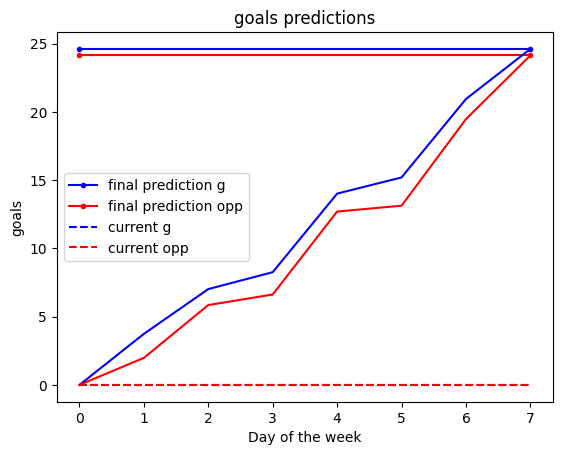

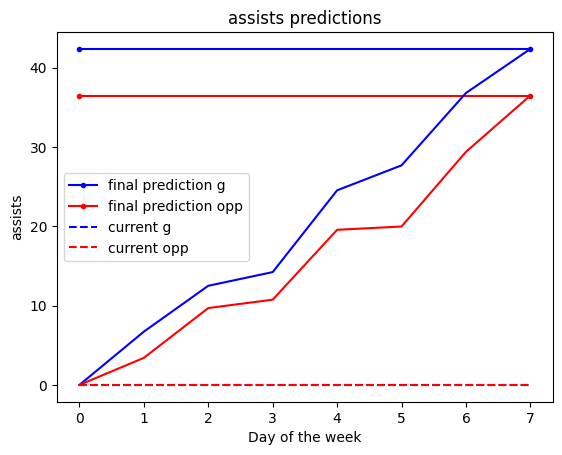

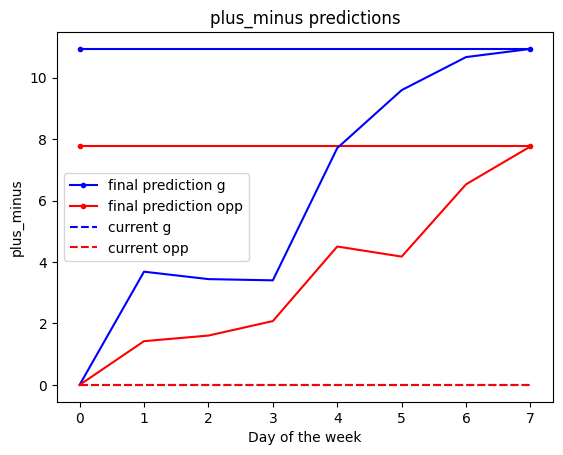

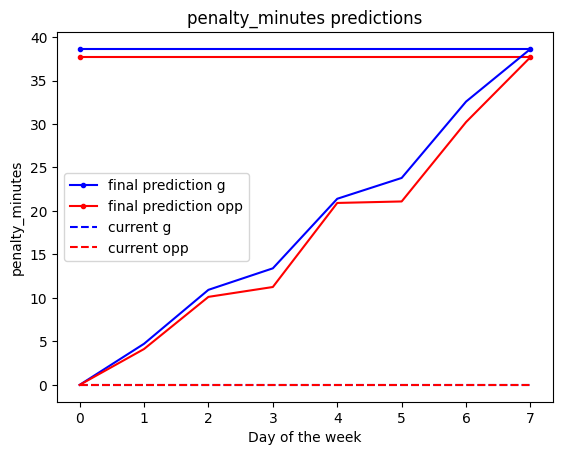

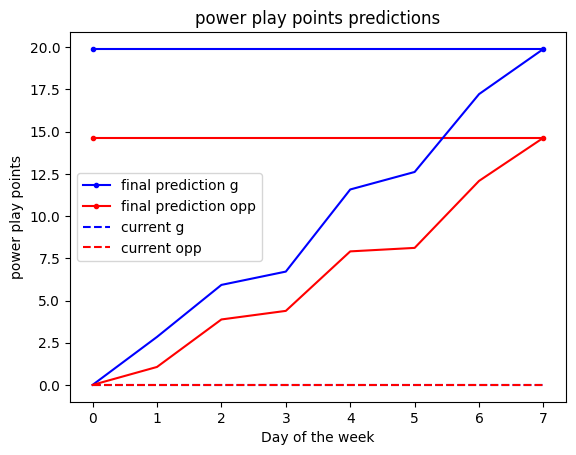

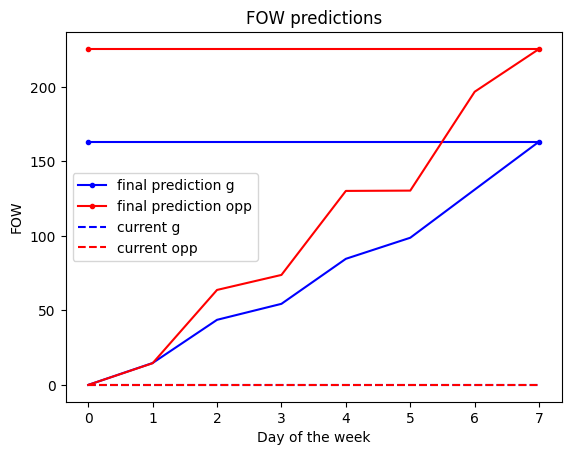

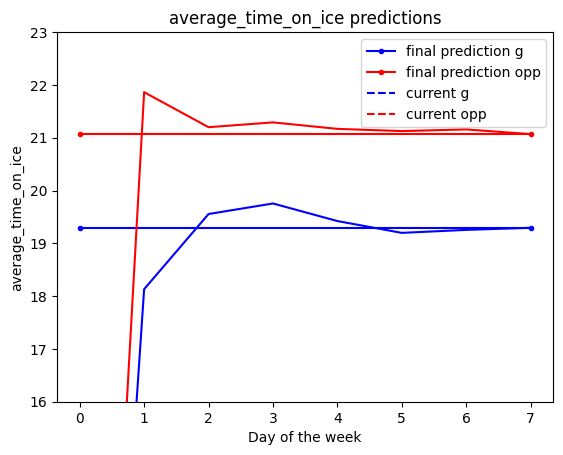

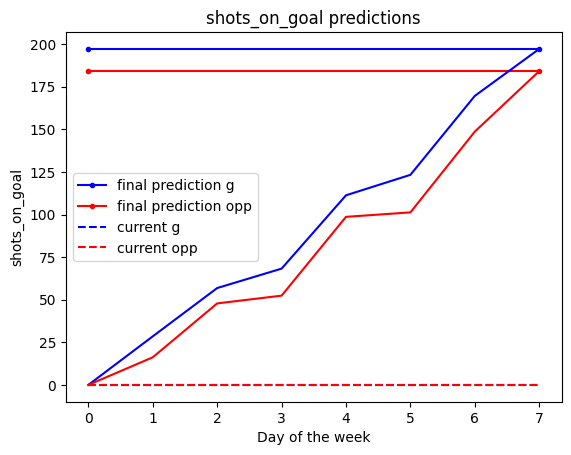

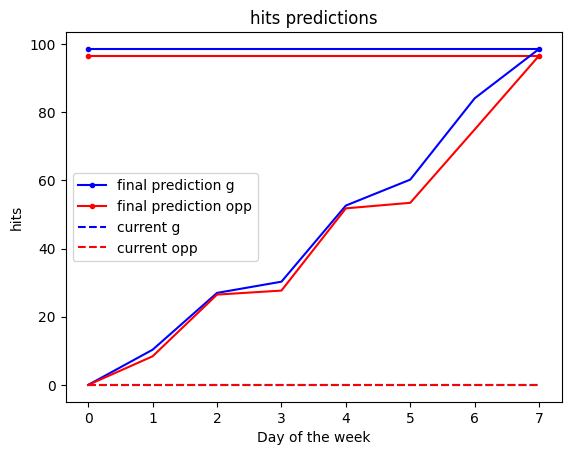

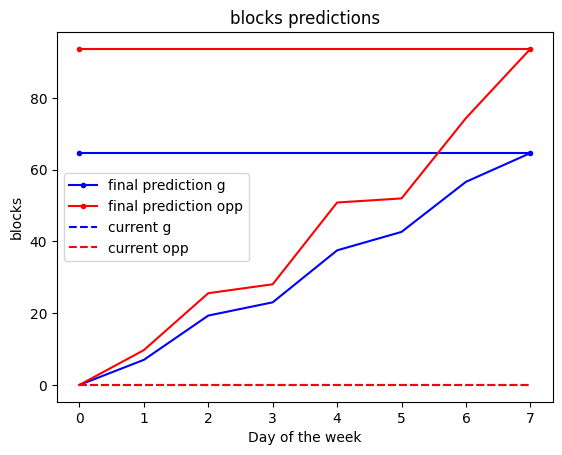

In [38]:
teams = (g_team,opp_team)
scores = (current_g_scores,current_opp_scores)
swapped_days = (swapped_days_g,swapped_days_opp)
dropped_days = (dropped_days_g,dropped_days_opp)
current_players = (current_g_players,current_opp_players)
overall_wins,win_cats,num_players = get_week_predictions(teams, played_players,games,skater_cats,scores,swapped_days,dropped_days,current_players,current_day=current_day,predict_tomorrow=predict_tomorrow)

print(overall_wins)
print("Win cats: ", win_cats)
print(num_players)